## 멀티 모달 RAG



## Packages

아래 pip 패키지들 외에도, 시스템에 `poppler` ([설치 안내](https://pdf2image.readthedocs.io/en/latest/installation.html)) 및 `tesseract` ([설치 안내](https://tesseract-ocr.github.io/tessdoc/Installation.html))가 필요합니다.

In [1]:
! pip install -U langchain openai langchain-chroma langchain-experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.4 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 5.0 MB/s eta 0:00:00 MB/s eta 0:00:01
  Attempting uninstall: openai
    Found existing installation: openai 1.34.0
    Uninstalling openai-1.34.0:
      Successfully uninstalled openai-1.34.0
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.2.30
    Uninstalling langchain-core-0.2.30:
      Successfully uninstalled langchain-core-0.2.30
  Attempting uninstall: langchain
    Found existing installation: langchain 0.2.13
    Uninstalling langchain-0.2.13:
      Successfully uninstalled langchain-0.2.13
  Attempting uninstall: langchain-community
    Found existing installation: langchain-community 0.2.12
    Uninstalling langchain-community-0.2.12:
      Successfully uninstalled langchain-community-0.2.12
  Attempting uninstall: langchain-chroma
    Found existing installation: langchain-chroma 0.1.2
 

In [2]:
! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

  Using cached protobuf-4.25.4-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
Using cached protobuf-4.25.4-cp37-abi3-macosx_10_9_universal2.whl (394 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.1.120 requires tiktoken<0.8.0,>=0.7.0, but you have tiktoken 0.5.2 which is incompatible.
grpcio-health-checking 1.65.4 requires grpcio>=1.65.4, but you have grpcio 1.63.0 which is incompatible.
grpcio-health-checking 1.65.4 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.4 which is incompatible.


## 데이터 로딩
### PDF의 표, 텍스트, 이미지 분할


In [70]:
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf


# PDF에서 요소 추출
def extract_pdf_elements(path, fname):
    """
    PDF 파일에서 이미지, 테이블, 텍스트 블록을 추출합니다.
    path: 파일 경로 (이미지 파일이 저장될 위치)
    fname: 파일 이름
    """
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=True,  # PDF에서 이미지를 추출
        infer_table_structure=True,  # 테이블 구조를 추론
        chunking_strategy="by_title",  # 타이틀을 기준으로 텍스트를 블록으로 분할
        max_characters=4000,  # 최대 4000자로 텍스트 블록을 제한
        new_after_n_chars=3800,  # 3800자 이후에 새로운 블록 생성
        combine_text_under_n_chars=2000,  # 2000자 이하의 텍스트는 결합
        image_output_dir_path=path,  # 이미지가 저장될 경로 설정
        # image_output_dir_path=os.path.join(os.getcwd(),"figures"),
    )


# 추출한 요소를 유형별로 분류
def categorize_elements(raw_pdf_elements):
    """
    PDF에서 추출한 요소들을 테이블과 텍스트로 분류합니다.
    raw_pdf_elements: unstructured.documents.elements 리스트
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))  # 테이블 요소를 저장
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))  # 텍스트 요소를 저장
    return texts, tables

In [71]:
import os

# 현재 실행 중인 스크립트의 디렉토리 경로를 찾습니다.
# script_directory = os.path.dirname(os.path.abspath(__file__))

current_directory = os.getcwd()
fname = "invest.pdf"
fpath = os.path.join(os.path.dirname(current_directory), "invest/")

print("현재 스크립트의 위치:", current_directory)
print("pdf 위치:",fpath)

현재 스크립트의 위치: /Users/usermackbookpro/langchain-python/langchain-python-book/langchain-pdf-multimodal/langchain-pdf-multimodal-openSource
pdf 위치: /Users/usermackbookpro/langchain-python/langchain-python-book/langchain-pdf-multimodal/invest/


### 요소 추출

`extract_pdf_elements(fpath, fname)`: PDF 파일의 경로와 이름을 받아서 PDF 요소를 추출합니다.

### 텍스트와 표 요소 분류

`categorize_elements(raw_pdf_elements)`: 추출된 요소를 텍스트와 표로 분류합니다.

### 선택사항: 텍스트의 특정 토큰 크기 강제 적용

`CharacterTextSplitter.from_tiktoken_encoder(...)`: 텍스트를 특정 크기로 분할하기 위해 텍스트 분할기를 초기화합니다.
- `chunk_size=2000`: 각 텍스트 청크의 최대 크기를 2000자로 설정합니다.
- `chunk_overlap=200`: 청크 간의 겹침을 200자로 설정합니다.
- `joined_texts = " ".join(texts)`: 모든 텍스트를 하나의 문자열로 결합합니다.
- `texts_2k_token = text_splitter.split_text(joined_texts)`: 결합된 텍스트를 설정한 크기와 겹침으로 분할합니다.

In [72]:
# PDF에서 요소 추출
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# 텍스트와 테이블 추출
texts, tables = categorize_elements(raw_pdf_elements)

# 선택 사항: 텍스트에 대해 특정 토큰 크기 적용
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=200
)
joined_texts = " ".join(texts)

# 2k 토큰 크기로 텍스트 분할
texts_2k_token = text_splitter.split_text(joined_texts)

In [73]:
# text 분할 개수 확인 
print(len(texts_2k_token))
print(len(texts))

3
2


In [74]:
print(texts[0])
print(type(texts))

<< () warsrts2

시황 코멘트 금리 멈춰야 주가 멈춘다

2024년 8월 5일 주식시황

“3 s LLL LL

FLISILLLLI LLL LL LLL LLL LLL LLL LLL LLL LLL LLL LL

Market Analyst 김수연 sooyeon.k@hanwha.com 3772-7628

ISM 46.8에 경기침체 오지 않습니다

2일 KOSPI가 101p빠져 2,676.2p까지 내렸다. 전일 7월 미 ISM제조업지수가 예상치를 밑돌며 경기에 대한 우려가 생겼 고 금리와 주가가 함께 하락한 영향이다. 이번주 발표된 빅테크와 반도체 기업들의 2분기 실적과 3분기 가이던스도 컨센 서스를 하회하는 케이스들이 많았다.

이날 국내 금리도 영향을 받으면서 10년 국고금리가 3%를 하회했고 주식시장은 그간 주도주 역할을 했던 반도체, 전력 기기를 중심으로 하락폭이 확대됐다. 삼성전자 -4%, SK하이닉스 -10%, HD현대일렉트릭 -13% 등이다.

7월 미 ISM제조업지수는 46.8p로 4개월 연속 하락했다. 예상치는 48.8p, 전월치는 48.5p였다. 수요가 전반적으로 둔화 되면서 신규 주문, 신규 수출주문, 수주잔고, 재고가 모두 낮은 수준에 머물렀다. 전저점인 2023년 6월 46.4p에 거의 근 접했다.

금리가 주가를 함께 끌어내리고 있어서 결국 금리 하락이 멈춰야 주가도 바닥을 잡을 수 있다. 당사 투자전략팀 채권담 당자는 올해 미국 10년금리 하단을 3.8%, 국고 10년금리 하단은 2.8%로 보고있다. 금리 바닥은 머지 않았다.

주가의 바닥은 두 가지로 가늠할 수 있을 것 같다. 채권과 주식의 수익률 격차와 주식 내 IT 비중이다.

ISM 46.8은 그 자체로 충격이었다기보다 포트폴리오의 변화를 부추기는 촉매였다고 생각한다. 올해 채권과 주식의 수익 률 격차가 벌어져 있다. 1976년 이후 채권의 평균수익률이 6.0%, 주식은 9.3%여서 역사적으로 3.2%p 정도의 차이가 난 다. 올해는 채권수익률 1.7%, 주식수익률 11.

In [75]:
print(texts_2k_token[0])
print(type(texts_2k_token))

<< () warsrts2

시황 코멘트 금리 멈춰야 주가 멈춘다

2024년 8월 5일 주식시황

“3 s LLL LL

FLISILLLLI LLL LL LLL LLL LLL LLL LLL LLL LLL LLL LL

Market Analyst 김수연 sooyeon.k@hanwha.com 3772-7628

ISM 46.8에 경기침체 오지 않습니다

2일 KOSPI가 101p빠져 2,676.2p까지 내렸다. 전일 7월 미 ISM제조업지수가 예상치를 밑돌며 경기에 대한 우려가 생겼 고 금리와 주가가 함께 하락한 영향이다. 이번주 발표된 빅테크와 반도체 기업들의 2분기 실적과 3분기 가이던스도 컨센 서스를 하회하는 케이스들이 많았다.

이날 국내 금리도 영향을 받으면서 10년 국고금리가 3%를 하회했고 주식시장은 그간 주도주 역할을 했던 반도체, 전력 기기를 중심으로 하락폭이 확대됐다. 삼성전자 -4%, SK하이닉스 -10%, HD현대일렉트릭 -13% 등이다.

7월 미 ISM제조업지수는 46.8p로 4개월 연속 하락했다. 예상치는 48.8p, 전월치는 48.5p였다. 수요가 전반적으로 둔화 되면서 신규 주문, 신규 수출주문, 수주잔고, 재고가 모두 낮은 수준에 머물렀다. 전저점인 2023년 6월 46.4p에 거의 근 접했다.

금리가 주가를 함께 끌어내리고 있어서 결국 금리 하락이 멈춰야 주가도 바닥을 잡을 수 있다. 당사 투자전략팀 채권담 당자는 올해 미국 10년금리 하단을 3.8%, 국고 10년금리 하단은 2.8%로 보고있다. 금리 바닥은 머지 않았다.

주가의 바닥은 두 가지로 가늠할 수 있을 것 같다. 채권과 주식의 수익률 격차와 주식 내 IT 비중이다.

ISM 46.8은 그 자체로 충격이었다기보다 포트폴리오의 변화를 부추기는 촉매였다고 생각한다. 올해 채권과 주식의 수익 률 격차가 벌어져 있다. 1976년 이후 채권의 평균수익률이 6.0%, 주식은 9.3%여서 역사적으로 3.2%p 정도의 차이가 난 다. 올해는 채권수익률 1.7%, 주식수익률 11.

## 멀티 벡터 리트리버

[멀티 벡터 리트리버](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary)를 사용하여 이미지(및/또는 텍스트, 표) 요약을 인덱싱하고, 원본 이미지(원본 텍스트 또는 표와 함께)를 검색합니다.

### 텍스트 및 표 요약

GPT-4 or llama3.1를 사용하여 표 및 선택적으로 텍스트 요약을 생성할 것입니다.

큰 청크 크기(예: 위에서 설정한 4k 토큰 청크)를 사용하는 경우 텍스트 요약을 권장합니다.

요약은 원본 표 및/또는 원본 텍스트 청크를 검색하는 데 사용됩니다.

In [76]:
import os
from dotenv import load_dotenv
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("openai api 키가 없습니다. 한번더 확인 부탁드립니다.")


In [77]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_ollama.llms import OllamaLLM

# 텍스트 요소의 요약 생성
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    텍스트 요소 요약 생성
    texts: str 리스트
    tables: str 리스트
    summarize_texts: 텍스트 요약 여부를 나타내는 부울 값
    """

    # Prompt 영어 버전
    # prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    # These summaries will be embedded and used to retrieve the raw text or table elements. \
    # Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """

    # Prompt 한국어 버전
    prompt_text_kor = """당신은 표와 텍스트를 요약하여 검색에 활용할 수 있도록 돕는 도우미입니다. \n 
    이 요약본들은 임베딩되어 원본 텍스트나 표 요소를 검색하는 데 사용될 것입니다. \n 
    주어진 표나 텍스트의 내용을 검색에 최적화된 간결한 요약으로 작성해 주세요. 요약할 표 또는 텍스트: {element}"""
    
    prompt = ChatPromptTemplate.from_template(prompt_text_kor)

    # 텍스트 요약 체인 설정
    # 모델: GPT-4o-mini or Llama3.1 모델 사용
    # model = ChatOpenAI(temperature=0, model="gpt-4o-mini")
    llamaModel = OllamaLLM(model="llama3.1:8b")
    summarize_chain = {"element": lambda x: x} | prompt | llamaModel | StrOutputParser()

    # 요약 결과를 저장할 빈 리스트 초기화
    text_summaries = []
    table_summaries = []

    # 텍스트가 주어졌고 요약이 요청된 경우 요약을 적용
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        # 요약을 하지 않는 경우 원본 텍스트를 그대로 사용
        text_summaries = texts

    # 테이블이 주어졌을 경우 테이블에 대해 요약 적용
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# 텍스트와 테이블 요약 생성
text_summaries, table_summaries = generate_text_summaries(
    texts_2k_token, tables, summarize_texts=True
)

In [78]:
print(text_summaries)



['시황 코멘트 금리 멈춰야 주가 멈춘다. \n\nKOSPI는 2,676.2로 하락했다. 금리는 10년 국고 3%를 초과했다. 주식은 반도체와 전력기기를 중심으로 하락했다.\n\n미 ISM 제조업 지수는 46.8로 4개월 연속 하락했다. 수요가 둔화되어 신규 주문, 신규 수출주문, 수주잔고, 재고가 모두 낮았다.\n\n금리가 끌어내린 주가는 금리 바닥을 잡아야 바닥을 잡을 수 있다. 투자전략팀은 미국 10년 금리 하단을 3.8%, 국고 10년 금리 하단을 2.8%로 보고있다.\n\n주가의 바닥은 채권과 주식의 수익률 격차와 주식 내 IT 비중이다.', 'IT의 가격 모멘텀과 비중은 줄고 있다. 모멘텀 ETF는 IT를 46.1%에서 34.5%까지 축소했고, S&P500 IT 비중 30.7%보다 높다. 이 전환은 주식시장 반등을 예견한다.', '이 자료는 투자자의 증권투자를 돕기 위해 작성된 문서이며, 저작권이 주식회사 [당사 이름] 에 있습니다. 불법적으로 복사하거나 배포하지 마세요. 이 자료에 포함된 내용은 신뢰할 수 있는 출처에서 가져온 정보입니다. 하지만 정확성이나 완전성을 보장하지 못해, 고객의 증권투자 결과와 관련하여 법적 책임을 지는 경우 증명자료로 사용될 수 없습니다.']


In [79]:
print(table_summaries)

[]


### GPT-4 Vision 및 LLaVA를 이용한 이미지 요약

이 스크립트는 이미지를 base64 형식으로 인코딩하고 GPT-4 Vision 및 LLaVA 모델을 사용하여 간결한 요약을 생성합니다.

#### 모듈 및 함수

1. **임포트**
    - `base64`, `os`, `requests`, `json`: 이미지를 인코딩하고 파일 작업을 처리하며 HTTP 요청을 수행하고 JSON 데이터를 처리합니다.
    - `HumanMessage` from `langchain_core.messages`: 메시지 처리를 위해 사용됩니다.

2. **함수 정의**
    - `encode_image(image_path)`: 이미지 파일을 base64 문자열로 인코딩합니다.
    - `image_summarize(img_base64, prompt)`: GPT-4 Vision을 사용하여 이미지 요약을 생성합니다.
    - `image_summarize_llava(img_base64, prompt)`: LLaVA를 사용하여 이미지 요약을 생성합니다.

3. **이미지 요약 프로세스**
    - `generate_img_summaries(path)`: 
        - 지정된 디렉토리에서 이미지를 base64 문자열로 인코딩합니다.
        - LLaVA를 사용하여 이미지 요약을 생성합니다.
        - base64로 인코딩된 이미지와 해당 요약의 리스트를 반환합니다.
        - 한국어 프롬프트(`prompt_kor`)와 영어 프롬프트(`prompt`)를 사용하여 요약을 생성합니다.

4. **실행**
    - 현재 작업 디렉토리를 가져옵니다.
    - 'figures' 디렉토리의 경로를 설정합니다.
    - 디렉토리 내 이미지에 대한 요약을 생성합니다.

#### 코드 실행

1. `encode_image`를 사용하여 이미지 파일을 base64 형식으로 인코딩합니다.
2. `image_summarize` 및 `image_summarize_llava`를 사용하여 요약을 생성합니다.
3. base64로 인코딩된 이미지와 해당 요약을 저장합니다.
4. 'figures' 디렉토리의 경로를 출력하고 해당 디렉토리의 이미지에 대한 요약을 생성합니다.

In [80]:
import base64
import os
import requests
import json
from langchain_core.messages import HumanMessage

# 이미지 파일을 base64 문자열로 인코딩하는 함수
def encode_image(image_path):
    """이미지의 base64 문자열 생성"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# 이미지 요약을 생성하는 함수 (OpenAI API 사용)
def image_summarize(img_base64, prompt):
    """이미지 요약 생성"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)
    
    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    print(msg)
    return msg.content


# LLaVA 모델을 사용하여 이미지 요약을 생성하는 함수
def image_summarize_llava(img_base64, prompt):
    """LLaVA를 사용하여 이미지 요약 생성"""
    payload = {
        "model": "llava:7b",
        "prompt": prompt,
        "images": [img_base64]
    }

    response = requests.post(
        "http://localhost:11434/api/generate", json=payload)

    # print("Response: ", response)
    print("Status Code: ", response.status_code)
    # print("Headers: ", response.headers)
    # print("Content: ", response.content)

    if response.status_code == 200:
        try:
            # 응답을 줄 단위로 처리
            full_response = ""
            for line in response.iter_lines():
                if line:
                    json_line = json.loads(line)
                    if 'response' in json_line:
                        full_response += json_line['response']
            print(full_response)
            return full_response
        except json.JSONDecodeError as e:
            return f"JSON 파싱 오류: {str(e)}\n응답 내용: {response.text}"
    else:
        return f"Error: {response.status_code}, {response.text}"

# 주어진 경로에서 이미지의 base64 인코딩 및 요약을 생성하는 함수
def generate_img_summaries(path):
    """
    이미지의 요약과 base64 인코딩 문자열을 생성
    path: Unstructured에 의해 추출된 .jpg 파일의 경로
    """

    # base64로 인코딩된 이미지를 저장할 리스트
    img_base64_list = []

    # 이미지 요약을 저장할 리스트
    image_summaries = []

    # Prompt_kor 한국어
    prompt_kor = """You are an assistant tasked with summarizing images for retrieval. 
    These summaries will be embedded and used to retrieve the raw image. Provide a concise summary of the image that is well optimized for retrieval. 
    The summary should be written in Korean (Hangul)."""

    # Prompt 영어
    prompt = """You are an assistant tasked with summarizing images for retrieval. 
    These summaries will be embedded and used to retrieve the raw image. Provide a concise summary of the image that is well optimized for retrieval. """



    # 주어진 경로에서 파일 목록을 가져와 정렬한 후, 각 파일에 대해 처리합니다.
    for img_file in sorted(os.listdir(path)):
    
        # 파일이 .jpg, .png, .jpeg 확장자 중 하나일 경우에만 처리합니다.
        if img_file.endswith((".jpg",".png",".jpeg")):
        
            # 파일의 전체 경로를 생성합니다.
            img_path = os.path.join(path, img_file)
        
            # 이미지 파일을 base64로 인코딩하여 문자열로 변환합니다.
            base64_image = encode_image(img_path)
        
            # 인코딩된 base64 문자열을 리스트에 추가합니다.
            img_base64_list.append(base64_image)
        
            # LLaVA 모델을 사용하여 이미지 요약을 생성하고 리스트에 추가합니다.
            # 또한, openai api의 image_summarize(base64_image, prompt_kor)를 사용하여 대체할 수도 있습니다.
            # 여기서는 한국어로 요약된 결과를 사용하고 있습니다.
            image_summaries.append(image_summarize_llava(base64_image, prompt_kor))
        
    return img_base64_list, image_summaries

# 현재 작업 디렉토리 경로를 찾습니다.
current_directory = os.getcwd()

# 현재 디렉토리를 기준으로 'figures' 폴더 경로를 설정합니다.
# os.path.dirname를 사용하여 부모 디렉토리를 찾습니다.
figures_directory = os.path.join(current_directory, "figures")

print(figures_directory)



# 이미지 요약 생성
img_base64_list, image_summaries = generate_img_summaries(figures_directory)

/Users/usermackbookpro/langchain-python/langchain-python-book/langchain-pdf-multimodal/langchain-pdf-multimodal-openSource/figures
Status Code:  200
 한글로 설명할 수 있는 이미지입니다.

이미지는 기사와 함께 발생하는 경제적 데이터를 나타내는 표시판을 보여주는 것으로, 삼성과 금융 기업의 투자 관련 그래프가 있습니다. 이미지에는 기사의 제목과 내용을 담고 있는 기사의 스크릷이 포함되어 있으며, 그 기사의 내용은 재무 분석과 잠재적 투자 위험성에 대한 설명을 담고 있습니다.

이미지를 반복하면서도 유사한 기사와 함께 보여진 표시판이 있는 것으로, 제목이나 내용에 따라 변경될 수 있습니다. 이미지는 재무 분석과 금융 기업의 투자 관련 데이터를 포함하고 있으므로, 재무, 금융, 투자 등의 분야에 대한 검색 결과가 맞을 것입니다. 
Status Code:  200
 "전국 통합신구와 전문 산업 자원의 1년간 증가율을 나타내는 그래프이며, 서울특별시와 서울대병 산업으로 분류된 데이터입니다. 전국의 증가율은 73%이고, 서울특별시의 증가율은 20%입니다. 반면에 서울대병산업은 10%으로 하늘어 감소하고 있습니다. 그래프는 2018년부터 2024년까지의 예측을 나타내며, 서울특별시와 전문산업에 대한 최근 비교를 보여줍니다." 
Status Code:  200
 한글 

이미지는 기업 재무제표 중 하나로, "주식 가격 변동"을 묘고 있습니다. 
Status Code:  200
 한글로 정리합니다.

먼저, 이미지는 국내 금융기관(국내은행)에서 발표된 데이터를 비롯한 시계열 그래프입니다. 그래프는 몇몇 제품의 매출액을 나타내며, 그 중 하나가 "세금 인력"으로 표시됩니다.

이미지는 한국어 언어로 작성된 데이터와 함께 표시되어 있습니다. 이러한 데이터는 금융기관에서 발표하였으며, 그 중 일부가 "세금 인력" 제품의 매출액을 나타내고 있습니다.

그래프는 시간

In [81]:
len(img_base64_list)


6

In [46]:
len(image_summaries)
image_summaries[1]

' 제목: 한국 국제경쟁과 세계경쟁 실적(2023년도)\n\n이미지는 한국의 국제경쟁과 세계경쟁 실적에 대한 보고서입니다. 국제경쟁은 13위로, 그 중 8개국가의 실적을 비교하여 세계경쟁 중 2개국가의 실적과 유사성을 나타냅니다.\n\n표에서 해당되는 국제경쟁은 한국의 성장속도를 보여주며, 대한민국, 중국, 일본 및 서울특별시도 등 8개국가의 실적이 나타납니다. 반면에 세계경쟁은 2023년도 전통형 경쟁과 유사성을 보여주는 그래프입니다.\n\n추가로, 한국의 경쟁성장률은 70%이며, 국제경쟁은 10위로 나타납니다. 한국의 경쟁력을 강조하는 그래프를 통해 유사성이 있음을 보여주고 있습니다.\n\n이미지는 정부에서 작성된 보고서를 통해 국제경쟁과 세계경쟁의 상태를 파악하고 있으며, 이를 사용하여 전략적인 결정을 내리는 데 중요한 보조자가 될 수 있습니다. '

### 다중 벡터 검색기 생성 및 사용

이 스크립트는 다중 벡터 검색기를 생성하여 텍스트, 표, 이미지 요약을 색인화하고 원본 이미지를 반환합니다.

#### 모듈 및 함수

1. **임포트**
    - `uuid`를 사용하여 고유 식별자를 생성합니다.
    - `MultiVectorRetriever`, `InMemoryStore`, `Chroma`, `Document`, `OpenAIEmbeddings`, `OpenCLIPEmbeddings`를 사용하여 검색기 및 벡터 저장소를 설정합니다.

2. **함수 정의**
    - `create_multi_vector_retriever(vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images)`: 
        - 요약을 색인화하고 원본 이미지를 반환하는 검색기를 생성합니다.
        - InMemoryStore를 초기화하고, MultiVectorRetriever를 생성합니다.
        - 도큐먼트를 벡터 저장소와 도큐먼트 저장소에 추가하는 헬퍼 함수를 정의합니다.
        - 텍스트, 표, 이미지 요약을 추가합니다.

3. **코드 실행**

1. **임포트 및 초기 설정**
    - 필요한 모듈 및 함수를 임포트합니다.
    - `OpenCLIPEmbeddings`를 사용하여 임베딩을 초기화합니다.
    - `Chroma` 벡터 저장소를 설정합니다.

2. **검색기 생성**
    - `create_multi_vector_retriever` 함수를 호출하여 다중 벡터 검색기를 생성합니다.
    - 텍스트, 표, 이미지 요약을 추가합니다.

In [82]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_experimental.open_clip import OpenCLIPEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    요약된 내용을 인덱싱하지만, 실제 검색 시 원본 이미지를 반환하는 검색기 생성
    """

    # 저장소 초기화
    store = InMemoryStore()
    id_key = "doc_id"

    # 다중 벡터 검색기 생성
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # 벡터 저장소와 문서 저장소에 문서를 추가하는 헬퍼 함수
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # 텍스트, 테이블, 이미지 추가
    # text_summaries가 비어 있지 않으면 추가
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # table_summaries가 비어 있지 않으면 추가
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # image_summaries가 비어 있지 않으면 추가
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# OpenCLIPEmbeddings 모델을 사용한 임베딩 설정
embedding = OpenCLIPEmbeddings()

# 요약본을 인덱싱하는 데 사용할 벡터 저장소 설정
vectorstore = Chroma(
    collection_name="mm_rag_finace", embedding_function=embedding
)

# 검색기 생성
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts_2k_token,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

In [83]:
img_base64_list[0]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIbAfMDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+ophmpTTWG6kBWwRSg5FSOvGBUYBAoAWgDmgdKBmgB/FOBFNooAeQCKZntS5xTSwzQAjDI4qPBFS0YzQBFT1GRTvLyc1IFA6UAIFNOHFOFFMBKWkzSEgd6TAXNNZwBUbSAVA8melZSn2GiV5arvIaYXJHNNAJ74rFyZaQbi

### 다중 모달 RAG 체인 생성 및 사용

이 스크립트는 다중 모달 RAG(Retrieval-Augmented Generation) 체인을 생성하여 텍스트, 표, 이미지 데이터를 처리하고, 한국어로 투자 조언을 제공합니다.

#### 모듈 및 함수

1. **임포트**
    - `io`, `re`, `IPython.display`, `langchain_core.runnables`, `langchain.prompts`, `PIL.Image`: 다양한 모듈을 사용하여 이미지 처리, 데이터 처리, 디스플레이, 체인 생성 등을 수행합니다.

2. **함수 정의**
    - `plt_img_base64(img_base64)`: Base64 인코딩된 문자열을 이미지로 표시합니다.
    - `looks_like_base64(sb)`: 문자열이 Base64 형식인지 확인합니다.
    - `is_image_data(b64data)`: Base64 데이터가 이미지인지 확인합니다.
    - `resize_base64_image(base64_string, size=(128, 128))`: Base64 형식의 이미지를 리사이즈합니다.
    - `split_image_text_types(docs)`: Base64로 인코딩된 이미지와 텍스트를 분리합니다.
    - `img_prompt_func(data_dict)`: 주어진 데이터 딕셔너리로부터 메시지를 생성합니다.
    - `multi_modal_rag_chain(retriever)`: 다중 모달 RAG 체인을 생성합니다.
    - `korean_convert_rag()`: 영어 텍스트를 한국어로 변환하는 RAG 체인을 생성합니다.

3. **코드 실행**

1. **임포트 및 초기 설정**
    - 필요한 모듈 및 함수를 임포트합니다.

2. **이미지 처리 및 변환**
    - Base64 인코딩된 이미지를 처리하고 표시합니다.
    - 문자열이 Base64 형식인지, Base64 데이터가 이미지인지 확인합니다.
    - 이미지를 리사이즈합니다.
    - Base64로 인코딩된 이미지와 텍스트를 분리합니다.

3. **메시지 생성**
    - 주어진 데이터 딕셔너리로부터 메시지를 생성합니다.
    - 투자 분석을 위한 프롬프트 메시지를 구성합니다.

4. **RAG 체인 생성**
    - 다중 모달 RAG 체인을 생성합니다.
    - 영어 텍스트를 한국어로 변환하는 RAG 체인을 생성합니다.
    - 다중 모달 RAG 체인과 한국어 변환 RAG 체인을 결합합니다.

In [84]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from PIL import Image


def plt_img_base64(img_base64):
    """base64로 인코딩된 문자열을 이미지로 표시"""
    # Base64 문자열을 소스로 하는 HTML img 태그 생성
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # HTML을 렌더링하여 이미지를 표시
    display(HTML(image_html))


def looks_like_base64(sb):
    """문자열이 base64 형식인지 확인"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    base64 데이터가 이미지인지 확인 (데이터 시작 부분을 검사)
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # base64 디코딩 후 처음 8바이트를 가져옴니다.
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Base64로 인코딩된 이미지를 크기 조정
    """
    # Base64 문자열을 디코딩
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # 이미지 크기 조정
    resized_img = img.resize(size, Image.LANCZOS)

    # 크기 조정된 이미지를 bytes 버퍼에 저장
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # 크기 조정된 이미지를 Base64로 인코딩
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Base64로 인코딩된 이미지를 크기 조정
    """
    b64_images = []
    texts = []
    for doc in docs:
        # 문서 유형이 Document일 경우 page_content 추출
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    주어진 맥락을 하나의 문자열로 결합하여 처리
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # 이미지가 있는 경우 메시지에 추가
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # 분석할 텍스트 추가
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}\n\n"
            "Please provide the final answer in Korean(hangul)."
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    다중 모드 RAG 체인 생성
    """

    # 다중 모드 LLM 설정
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)
    llava_model = OllamaLLM(model="llava:7b")
    # RAG 파이프라인 설정
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | llava_model # model
        | StrOutputParser()
    )

    return chain


def korean_convert_rag():
    """
    영어 텍스트를 한국어로 변환하는 RAG 체인
    """
    # or gpt-4 oepn-ai 모델 선택부분은 공식 홈페이지에서 확인 가능합니다. 현재는 gpt-3.5-turbo 모델을 사용하겠습니다.
    # model = ChatOpenAI(model="gpt-3.5-turbo",temperature=0)
    llamaModel = OllamaLLM(model="llama3.1:8b")

    # 프롬프트 템플릿 설정
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that translates English to Korean."),
        ("human", "Translate the following English text to Korean: {english_text}")
    ])

    # RAG 파이프라인 설정
    chain = (
        {"english_text": RunnablePassthrough()}
        | prompt
        | llamaModel #또는 다른 모델 사용 가능
        | StrOutputParser()
    )

    return chain

    

# RAG 체인 생성
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

#openSource model 사용시 답변이 영어로 나온다면 korean_convert_rag를 chain을 생성하여서 rag 진행
korean_convert_rag = korean_convert_rag()
final_multimodal_rag = chain_multimodal_rag | korean_convert_rag



### 조회 결과 확인

주어진 질문에 관련된 이미지를 검색하여 반환합니다.

In [85]:
query = "주가변동률에 가장 관련있는 자료를 찾아줘"
docs = retriever_multi_vector_img.invoke(query)

len(docs)

4


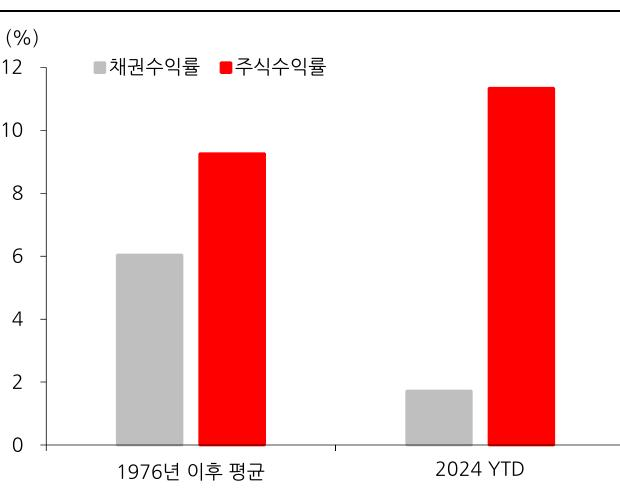

In [97]:
# 첫 번쨰 문서를 이미지로 표시합니다
plt_img_base64(docs[1])

### 검증
왜 이 방법이 효과적인지 이해하기 위해 저장한 이미지를 다시 봅시다.


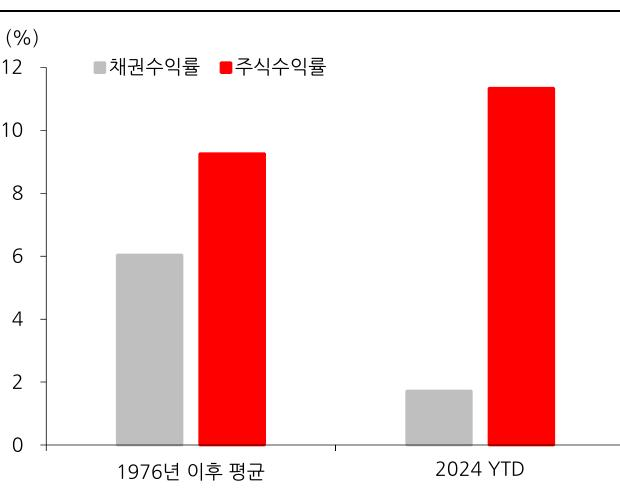

In [98]:
# 찾아준 이미지와 저정된 이미지의 순서를 확인하여서 이미지 요약 내용이 질문이랑 연관성이 있는지 확인해봅니다.
plt_img_base64(img_base64_list[4])

In [99]:
# 해당 이미지의 요약을 확인합니다
image_summaries[4]

' 정부 신관리 예산 비율 차트 '

### RAG 실행
질문에 대한 종합적인 답변을 생성하기 위해 RAG를 실행합니다.

In [100]:
# RAG 체인 실행
query = "코스피 관련해서 전망을 종합적으로 알려줘"
chain_multimodal_rag.invoke(query)

' 코스피와 관련된 전망을 종합적으로 알려드리겠습니다.\n\n1. 시장 동향 : 코스피는 한국의 주택 시장에서 가장 대표적인 주식 지수입니다. 최근 한국 주택 시장은 부동산 시장 전반적으로 인해 퇴망을 경험하고 있습니다. 이로 인해 코스피 지수도 전망에 따라 유리한 변동이 예상됩니다.\n2. 기업 수익 및 재무 실적 : 코스피는 주식의 가격 증가와 감소에 따라 산정됩니다. 고객들은 기업의 재무 실적과 성장 율률을 평가하여 주식의 가치를 판단합니다.\n3. 제공되는 제품 : 코스피는 대리투자(ETF)와 기초금융제품과 같은 상대적으로 비교적 안정한 수익을 제공합니다. 이로 인해 코스피를 통해 고객들은 주식 투자에서의 리스크를 줄일 수 있습니다.\n4. 시장 동향 : 한국 재무 및 재화 산업에서 큰 영향을 미치고 있습니다. 따라서 코스피의 가격은 이 영역의 성과와 관련됩니다.\n5. 투자 전략 : 주식 투자는 잠재적인 수익을 위해 고객들에게 필요한 수단입니다. 따라서 코스피를 통해 고객들은 리스크를 취하며, 그 리스크를 어떻게 관리할지 중요합니다.\n\n즉, 코스피와 관련된 전망에서는 시장 동향, 기업의 수익 및 재무 실적, 제공되는 제품, 시장 동향, 투자 전략 등 다양한 요인을 고려해야 합니다. 이러한 요인들에 따라 코스피의 가격은 변동할 것으로 예상됩니다.\n\n만약 주식 투자에서 고객들의 리스크를 줄이기 위해 ETF와 같은 상대적으로 안정한 제품을 고려하는 것도 좋습니다. 그러나, 전망에 따라 시장 동향과 기업의 수익 및 재무 실적에 따라 코스피의 가격은 변동할 것으로 예상됩니다. 따라서 고객들은 적정한 투자 전략을 선택하여, 리스크를 관리해야 합니다. '

In [101]:
# openSource 사용시 영어로 답변이 나온다면 최종 멀티모달 RAG 체인 실행
final_multimodal_rag.invoke(query)

'Here is the translation of the English text to Korean:\n\n**코스피 관련 전망을 종합적으로 알려드리겠습니다.**\n\n현재, **코스피( Korea Stock Price Index)**는 한국의 주요 첨도표 중 하나이며 대부분의 고용비자와 정부기관들의 주식과 주식회사 등에서 보유하고 있습니다.\n\n전망은 국내 경쟁력 강화, 신생 기업의 성장적인 기여, 정부 지원, 일자리스트 비전지화 등 다양한 요소에 따라 변동될 수 있습니다.\n\n**코스피( Korea Stock Price Index)**는 매우 안정하고 장기적으로 투자할 가치의 대표 산업입니다. 그러나, 국내 경쟁력 강화와 신생 기업의 성장적인 기여로 인해 매출과 이익이 좋아지고 있으며, 국외 투자자들에게도 유명한 대표 산업으로 인해 전세계에서 투자자들의 관심을 받고 있습니다.\n\n따라서, **코스피( Korea Stock Price Index)**는 장기적인 투자 정책과 상대적으로 안전한 산업이며, 국내 경쟁력 강화와 신생 기업의 성장적인 기여 등에 따라 매출과 이익이 좋아지고 있습니다.\n\n그러나, 정부와 국내 경제가 어떻게 변화하는지에 따라 **코스피( Korea Stock Price Index)**의 전망은 달라질 수 있으며, 국외 투자자들도 여기 투자할 수 있습니다.\n\n따라서, **코스피( Korea Stock Price Index)**는 장기적인 투자 정책과 상대적으로 안전한 산업이며, 국내 경쟁력 강화와 신생 기업의 성장적인 기여 등에 따라 매출과 이익이 좋아지고 있습니다.\n\n이외, 국내 경제가 어떻게 변화하는지에 따라 **코스피( Korea Stock Price Index)**의 전망은 달라질 수 있으며, 국외 투자자들도 여기 투자할 수 있습니다.'

### 고려 사항

**조회**

- 조회는 이미지 요약 및 텍스트 조각과의 유사성을 기반으로 수행됩니다.
- 텍스트 조각이 많을 경우 이미지 조회가 실패할 수 있습니다.

**이미지 크기**

- 답변의 품질은 이미지 크기에 민감합니다. [참고: OpenAI Vision 가이드](https://platform.openai.com/docs/guides/vision).
- 이를 더 면밀히 테스트하기 위해 평가를 수행할 예정입니다.